# dcTMD 2D test potential and pathway sorting

This notebook contains the 2D test potential as described in Wolf, Post and Stock (2023) in cartesian and polar coordinates, as well as all MC/LE calculations described therein. Requires to generate a "figs" and a "saves" directory in the same path as the notebook.

In [1]:
%matplotlib inline
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc, cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from IPython.display import HTML

import pickle
import copy
import numpy as np
import scipy, scipy.stats as stats, scipy.special as sps, scipy.integrate as integ

matplotlib.rcParams.update({'font.size': 22})

**general parameters**

In [2]:
RT = 1 # units of kT 
#RT = 0.0083144598*293.15 # in kJ/mol

**anisotropic 2D potential model**

In [74]:
box = np.array((351,351))

x = np.arange(0,box[0],1)
y = np.arange(0,box[1],1)

center = 0 #1.75
hole = [.50+center,center]

X, Y = np.meshgrid(x/100-1.75,y/100-1.75)

Z = ( 140.*stats.norm.pdf(X,loc=center,scale=.50)*stats.norm.pdf(Y,loc=center,scale=.50) \
            - 31.2 * stats.norm.pdf(X,loc=center,scale=.25)*stats.norm.pdf(Y,loc=center,scale=.25) \
            - 11. * stats.norm.pdf(X,loc=hole[0],scale=.30)*stats.norm.pdf(Y,loc=hole[1],scale=.15) \
            - 9.8 * stats.norm.pdf(X,loc=hole[1],scale=.15)*stats.norm.pdf(Y,loc=hole[0],scale=.25) ) * RT

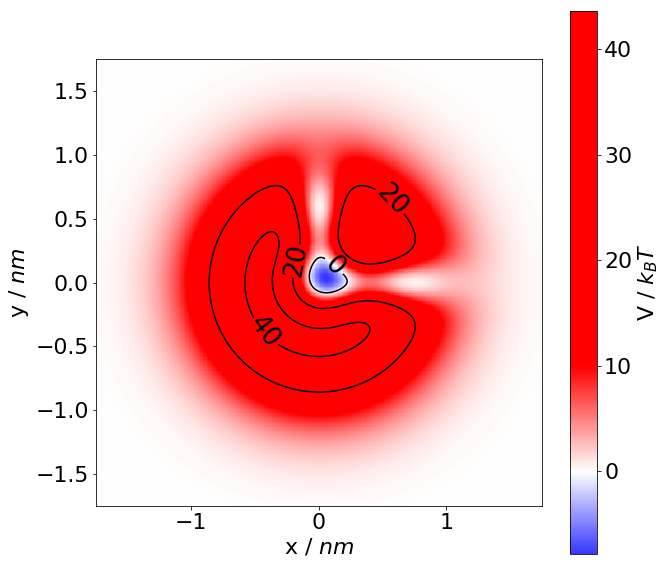

In [76]:
fig = plt.figure(figsize=(10, 10))

ax = plt.imshow(Z,origin='lower',cmap=cm.get_cmap('bwr'),extent=[-1.75,1.75,-1.75,1.75])

plt.xlabel('x / $nm$')
plt.ylabel('y / $nm$')

cbar = plt.colorbar()
cbar.set_clim(-10.,10.)
cbar.set_label('V / $k_BT$')

contours = [  0.,   20.,  40.]

ax2 = plt.contour(Z,origin='lower',levels=contours,colors='black',extent=[-1.75,1.75,-1.75,1.75])
ax2.clabel(contours, fmt='%1.0f', inline=True, fontsize=26)

plt.savefig('figs/hamiltonian_twoexits.pdf',bbox_inches='tight',origin='lower')

plt.show()

* **ATTENTION:** x and y are exchanged in Z!

In [4]:
x = np.linspace(-17.5,17.5,351)

* polar coordinate transformation, integration and differentiation

In [5]:
R = np.arange(0,175,1)
phi = np.arange(0,2*np.pi,2*np.pi/360)
phase = 180*2*np.pi/360
ray = np.zeros((len(phi),len(R)))
#inc_R = np.zeros((len(R)))

for i in range(len(phi)):
    for j in range(len(R)):
        ray[i,j] = Z[int(np.around((R[j])*np.sin(phi[i]-phase)+center)),int(np.around(R[j]*np.cos(phi[i]-phase)+center))]
        
diff_ray = np.zeros((len(phi),len(R)))
diff_ray[:,1:] = -np.diff(ray,n=1,axis=1)

* calculation of Boltzmann weigths

In [7]:
Boltz_weight = np.zeros((len(phi),len(R)))
Boltz_weight = np.exp(-ray/RT) 

* partition function

In [8]:
part_funct = np.zeros(len(R))
part_funct = (2 * np.pi * R) * np.sum(Boltz_weight,axis=0) ## with delta function on R

* ideal TI integration

In [9]:
mean_diff_ray = np.zeros(len(R))
mean_diff_ray[1:] = (2 * np.pi * R[1:]) * np.sum(diff_ray[:,1:] * Boltz_weight[:,1:],axis=0) / part_funct[1:]

id_TI = np.zeros(len(R))
id_TI[1:] = scipy.integrate.cumtrapz(-mean_diff_ray,R) - RT*np.log(2*np.pi*R[1:]) #last term is a projection artefact correction

In [10]:
dG_TD = np.zeros(len(R))
dG_TD[1:] = -RT*np.log(part_funct[1:])

In [14]:
x = np.linspace(0,1.74,175)
x1 = np.linspace(-1.75,1.75,351)

# MC Solver thermodynamic integration (TI)

* **setup**

In [13]:
RT = 1 #8.3144621*T_ref # in J/mol
dxy = 100.
windows = 18
box = len(phi)

accept_steps = 500000
max_steps =   10000000

windows_line = np.linspace(1,171,windows)

p1_TI = np.zeros((windows,accept_steps)) #path 1
p2_TI = np.zeros((windows,accept_steps)) #path 2
V1_TI = np.zeros((windows,accept_steps))
V2_TI = np.zeros((windows,accept_steps))
f1_TI = np.zeros((windows,accept_steps))
f2_TI = np.zeros((windows,accept_steps))

i=0
move=0


for j in range(windows):
    p1_TI[j,i] = 180.
    p2_TI[j,i] = 270.
    V1_TI[j,i] = ray[int(windows_line[j]),0]
    V2_TI[j,i] = ray[int(windows_line[j]),174]
    f1_TI[j,i] = diff_ray[int(windows_line[j]),0]
    f2_TI[j,i] = diff_ray[int(windows_line[j]),174]

add = 0

* PBC solver:

In [14]:
def jumpray(py):
    pyout = py % box
    return pyout

* carry out MC simulation path 1:

In [405]:
j = 0

for j in range(windows):
    i = 1
    move = 0
    dE = 0.0
    lnexpdE = 0.0

    while i < accept_steps:

        # perform MC 
        y_rand = np.random.standard_normal(1)
        y_add = y_rand*dxy*(1/windows_line[j]*10) #for modifying step size based Jacobian on distance from center  
        
        V1_TI[j,i] = ray[int(jumpray(p1_TI[j,i-1]+y_add)),int(windows_line[j])]
        
        #Metropolis acceprance criterion:
        dE = V1_TI[j,i] - V1_TI[j,i-1]
    #    expdE = np.exp(-dE/(8.3144621*T_ref))
        lnexpdE = -dE/RT #doing the ln to avoid overflow of exponential function
    #    print(dE)
        if dE <= 0:
            p1_TI[j,i] = int(jumpray(p1_TI[j,i-1]+y_add))
            V1_TI[j,i] = ray[int(p1_TI[j,i]),int(windows_line[j])]
            f1_TI[j,i] = diff_ray[int(p1_TI[j,i]),int(windows_line[j])]         
            if i % 10000 == 0:
                print("accepted step ",i," position ",p1_TI[j,i]," window ",j," E_pot=", V1_TI[j,i], " dE=", dE)
            i = i + 1 
                     
    #    elif expdE > np.random.rand(1):
        elif lnexpdE > np.log(np.random.rand(1)):
            p1_TI[j,i] = int(jumpray(p1_TI[j,i-1]+y_add))
            V1_TI[j,i] = ray[int(p1_TI[j,i]),int(windows_line[j])]
            f1_TI[j,i] = diff_ray[int(p1_TI[j,i]),int(windows_line[j])]   
            if i % 10000 == 0:
                print("accepted step ",i," position ",p1_TI[j,i]," window ",j," E_pot=", V1_TI[j,i], " dE=", dE)
            i = i + 1  

        else:
            p1_TI[j,i] = int(jumpray(p1_TI[j,i-1]))
            V1_TI[j,i] = ray[int(p1_TI[j,i]),int(windows_line[j])]
            f1_TI[j,i] = diff_ray[int(p1_TI[j,i]),int(windows_line[j])] 
            i = i + 1
            #print("unsuccesfull step, try again")
    
        if i > max_steps:
            break


accepted step  40000  position  150.0  window  0  E_pot= -5.63916193403  dE= 0.0
accepted step  50000  position  76.0  window  0  E_pot= -5.14907158747  dE= 1.38895969811
accepted step  80000  position  289.0  window  0  E_pot= -6.04994064753  dE= 0.0
accepted step  90000  position  355.0  window  0  E_pot= -5.0656981922  dE= 0.0
accepted step  100000  position  91.0  window  0  E_pot= -5.14907158747  dE= 0.994463679193
accepted step  120000  position  358.0  window  0  E_pot= -5.0656981922  dE= 1.07783707446
accepted step  130000  position  220.0  window  0  E_pot= -6.53803128558  dE= -0.488090638041
accepted step  150000  position  214.0  window  0  E_pot= -6.53803128558  dE= -0.488090638041
accepted step  160000  position  136.0  window  0  E_pot= -5.63916193403  dE= 0.504373332628
accepted step  180000  position  336.0  window  0  E_pot= -5.0656981922  dE= -0.501980798485
accepted step  190000  position  258.0  window  0  E_pot= -6.04994064753  dE= -0.900869060069
accepted step  20

* pickle write/load

In [406]:
MC_TI_path1_data = np.array([p1_TI,V1_TI,f1_TI])

pickle.dump( MC_TI_path1_data, open( "saves/MC_TI_path1_data_save.p", "wb" ) )

In [13]:
MC_TI_path1_data = pickle.load( open( "saves/MC_TI_path1_data_save.p", "rb" ) )

p1_TI = MC_TI_path1_data[0]
V1_TI = MC_TI_path1_data[1]
f1_TI = MC_TI_path1_data[2]

* carry out MC simulation path 2:

In [407]:
j = 0

for j in range(windows):
    i = 1
    move = 0
    dE = 0.0
    lnexpdE = 0.0

    while i < accept_steps:

        # perform MC 
        y_rand = np.random.standard_normal(1)
        y_add = y_rand*dxy*(1/windows_line[j]*10) #for modifying step size based Jacobian on distance from center  
        
        V2_TI[j,i] = ray[int(jumpray(p2_TI[j,i-1]+y_add)),int(windows_line[j])]
        
        #Metropolis acceprance criterion:
        dE = V2_TI[j,i] - V2_TI[j,i-1]
    #    expdE = np.exp(-dE/(8.3144621*T_ref))
        lnexpdE = -dE/RT #doing the ln to avoid overflow of exponential function
    #    print(dE)
        if dE <= 0:
            p2_TI[j,i] = int(jumpray(p2_TI[j,i-1]+y_add))
            V2_TI[j,i] = ray[int(p2_TI[j,i]),int(windows_line[j])]
            f2_TI[j,i] = diff_ray[int(p2_TI[j,i]),int(windows_line[j])]         
            if i % 10000 == 0:
                print("accepted step ",i," position ",p2_TI[j,i]," window ",j," E_pot=", V2_TI[j,i], " dE=", dE)
            i = i + 1 
                     
    #    elif expdE > np.random.rand(1):
        elif lnexpdE > np.log(np.random.rand(1)):
            p2_TI[j,i] = int(jumpray(p2_TI[j,i-1]+y_add))
            V2_TI[j,i] = ray[int(p2_TI[j,i]),int(windows_line[j])]
            f2_TI[j,i] = diff_ray[int(p2_TI[j,i]),int(windows_line[j])]   
            if i % 10000 == 0:
                print("accepted step ",i," position ",p2_TI[j,i]," window ",j," E_pot=", V2_TI[j,i], " dE=", dE)
            i = i + 1  

        else:
            p2_TI[j,i] = int(jumpray(p2_TI[j,i-1]))
            V2_TI[j,i] = ray[int(p2_TI[j,i]),int(windows_line[j])]
            f2_TI[j,i] = diff_ray[int(p2_TI[j,i]),int(windows_line[j])]   
            i = i + 1
            #if i%1000 == 0:
            #    print("unsuccesfull step, try again")
    
        if i > max_steps:
            break


accepted step  20000  position  87.0  window  0  E_pot= -5.14907158747  dE= 0.0
accepted step  30000  position  192.0  window  0  E_pot= -6.14353526666  dE= 0.0
accepted step  40000  position  226.0  window  0  E_pot= -6.53803128558  dE= -0.488090638041
accepted step  50000  position  235.0  window  0  E_pot= -6.53803128558  dE= -0.488090638041
accepted step  60000  position  169.0  window  0  E_pot= -6.14353526666  dE= -0.0935946191233
accepted step  70000  position  324.0  window  0  E_pot= -5.46258674526  dE= 0.587353902277
accepted step  80000  position  247.0  window  0  E_pot= -6.04994064753  dE= 0.0
accepted step  90000  position  357.0  window  0  E_pot= -5.0656981922  dE= 0.396888553061
accepted step  110000  position  103.0  window  0  E_pot= -5.14907158747  dE= 0.994463679193
accepted step  120000  position  307.0  window  0  E_pot= -5.46258674526  dE= 0.176575188772
accepted step  140000  position  35.0  window  0  E_pot= -4.56371739371  dE= 1.48622325382
accepted step  150

* pickle write/load

In [408]:
MC_TI_path2_data = np.array([p2_TI,V2_TI,f2_TI])

pickle.dump( MC_TI_path2_data, open( "saves/MC_TI_path2_data_save.p", "wb" ) )

In [14]:
MC_TI_path2_data = pickle.load( open( "saves/MC_TI_path2_data_save.p", "rb" ) )

p2_TI = MC_TI_path2_data[0]
V2_TI = MC_TI_path2_data[1]
f2_TI = MC_TI_path2_data[2]

In [410]:
p_bins = 360

p1_hist = np.zeros((windows,p_bins))
p1_dG = np.zeros((windows,p_bins))
p1_edges = np.zeros((windows,p_bins+1))
p2_hist = np.zeros((windows,p_bins))
p2_dG = np.zeros((windows,p_bins))
p2_edges = np.zeros((windows,p_bins+1))

for j in range(windows):
    p1_hist[j],p1_edges[j] = np.histogram(p1_TI[j],range=[0,360],bins=p_bins)
    p2_hist[j],p2_edges[j] = np.histogram(p2_TI[j],range=[0,360],bins=p_bins)

p1_dG = -np.log(p1_hist)
p2_dG = -np.log(p2_hist)

p1_dG_shift = p1_dG - np.min(p1_dG)
p2_dG_shift = p2_dG - np.min(p2_dG)

/Users/Steffen/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Users/Steffen/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


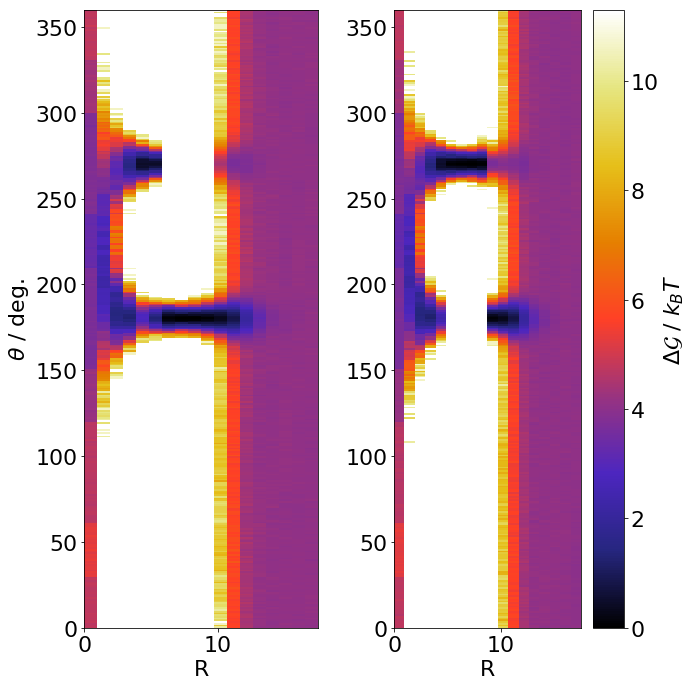

In [411]:
fig = plt.figure(figsize=(10, 10))
#plt.subplots_adjust(right=0.5)

plt.subplot(1,2,1)
plt.imshow(p1_dG_shift.T,origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,17.5,0.,360.])
plt.ylabel(r'$\theta$ / deg.')
plt.xlabel('R')
plt.subplot(1,2,2)
plt.imshow(p2_dG_shift.T,origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,17.5,0.,360.])
plt.xlabel('R')
plt.colorbar().set_label('$\Delta \mathcal{G}$ / $k_BT$')
fig.tight_layout()

plt.savefig('figs/TI_radial_distributions_MC_twoexits.pdf',bbox_inches='tight',origin='lower')

plt.show()

In [412]:
mean_f1_TI = np.mean(f1_TI,axis=1)
mean_f2_TI = np.mean(f2_TI,axis=1)

In [413]:
longer_windows_line = np.insert(windows_line,0,windows_line[0]-windows_line[1])

longer_mean_f1_TI = np.insert(mean_f1_TI,0,0)
longer_mean_f2_TI = np.insert(mean_f2_TI,0,0)

MC_PMF1 = np.zeros(len(longer_mean_f1_TI))
MC_PMF2 = np.zeros(len(longer_mean_f2_TI))

MC_PMF1[1:] = -scipy.integrate.cumtrapz(longer_mean_f1_TI,longer_windows_line) - RT*np.log(2*np.pi*np.linspace(0,174,19)[1:]) #last term is a projection artefact correction
MC_PMF2[1:] = -scipy.integrate.cumtrapz(longer_mean_f2_TI,longer_windows_line) - RT*np.log(2*np.pi*np.linspace(0,174,19)[1:]) #last term is a projection artefact correction

In [415]:
x = np.linspace(0,17.4,175)

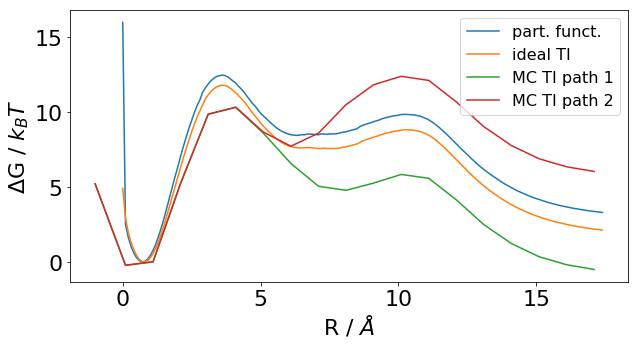

In [416]:
fig = plt.figure(figsize=(10, 5))

dG_statmech, = plt.plot(x,dG_TD-np.min(dG_TD))
id_PMF, = plt.plot(x,id_TI-np.min(id_TI))
MC_TI1, = plt.plot(longer_windows_line/10,MC_PMF1-MC_PMF1[2])
MC_TI2, = plt.plot(longer_windows_line/10,MC_PMF2-MC_PMF1[2])

plt.legend((dG_statmech,id_PMF,MC_TI1,MC_TI2),\
           ("part. funct.","ideal TI","MC TI path 1","MC TI path 2"), prop={'size': 16})

plt.xlabel('R / $\AA$')
plt.ylabel('$\Delta$G / $k_BT$')

plt.savefig('figs/MC_biased_TI_twoexits_newMC.pdf',bbox_inches='tight')

plt.show()

# dcTMD MC mimick

* setup:

In [15]:
Gamma_field = np.ones((len(phi),len(R)))

for phi_i in range(len(phi)):                  # with these definitions: ∆t = 1 ps
    for R_i in range(10,100):
        if (phi_i > 140 and phi_i < 220):
            Gamma_field[phi_i,R_i] = 5 #in k_BT \Delta t/\AA^{2}
        else:
            Gamma_field[phi_i,R_i] = 15 #10 #7

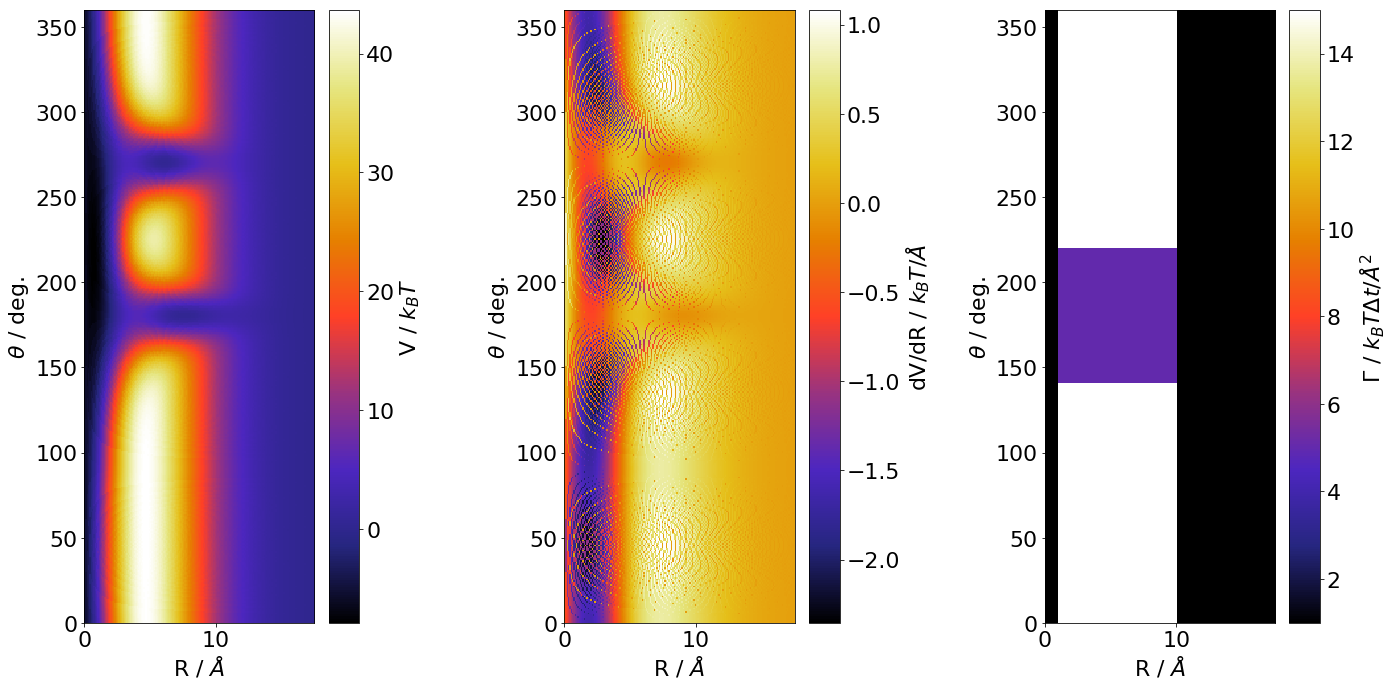

In [48]:
fig = plt.figure(figsize=(20, 10))
plt.subplots_adjust(right=0.5)

plt.subplot(1,3,1)
#plt.imshow(Boltz_weight)
plt.imshow(ray,origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,17.5,0.,360.])
plt.xlabel('R / $\AA$')
plt.ylabel(r'$\theta$ / deg.')
plt.colorbar().set_label('V / $k_BT$')
plt.subplot(1,3,2)
plt.imshow(diff_ray,origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,17.5,0.,360.])
plt.xlabel('R / $\AA$')
plt.ylabel(r'$\theta$ / deg.')
plt.colorbar().set_label('dV/dR / $k_BT/\AA$')
plt.subplot(1,3,3)
plt.imshow(Gamma_field,origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,17.5,0.,360.])
plt.xlabel('R / $\AA$')
plt.ylabel(r'$\theta$ / deg.')
plt.colorbar().set_label('$\Gamma$ / $k_BT \Delta t/\AA^{2}$ ')
fig.tight_layout()
plt.savefig('figs/dcTMDruns.pdf',bbox_inches='tight',origin='lower')
plt.show()

* PBC solver:

In [16]:
def jumpray(py):
    pyout = py % box[1]
    return pyout

## dcTMD MC calculation with structured friction

In [20]:
RT = 1 #8.3144621*T_ref # in J/mol
dxy = 100.
vc = 0.025 # with these definitions: ∆t = 1 ps
dcTMD_runs = 5000
box = np.array([len(R),len(phi)])
box_counts = np.zeros([len(R),len(phi)])

accept_steps = box[0]/vc

p_dcTMD = np.zeros((dcTMD_runs,int(box[0]/vc))) #path 1
V_dcTMD = np.zeros((dcTMD_runs,int(box[0]/vc)))
f_dcTMD = np.zeros((dcTMD_runs,int(box[0]/vc)))

i=0
move=0

for j in range(dcTMD_runs):
    p_dcTMD[j,i] = int(box[1]*np.random.random_sample())
    V_dcTMD[j,i] = ray[int(p_dcTMD[j,i]),0]
    f_dcTMD[j,i] = diff_ray[int(p_dcTMD[j,i]),0]
    box_counts[i,int(p_dcTMD[j,i])] += 1

add = 0

In [271]:
j = 0
vc = 0.025

for j in range(dcTMD_runs):
    print("run No. ",j)
    i = 1
    move = 0
    dE = 0.0
    lnexpdE = 0.0

    while i < accept_steps:

        # perform MC 
        y_rand = np.random.standard_normal(1)
        y_add = y_rand*dxy*(1/(i*vc)*10) #for modifying step size based Jacobian on distance from center  
        
        V_dcTMD[j,i] = ray[int(jumpray(p_dcTMD[j,i-1]+y_add)),int(i*vc)]
        
        #Metropolis acceprance criterion:
        dE = V_dcTMD[j,i] - V_dcTMD[j,i-1]
    #    expdE = np.exp(-dE/(8.3144621*T_ref))
        lnexpdE = -dE/RT #doing the ln to avoid overflow of exponential function
    #    print(dE)
        if dE <= 0:
            p_dcTMD[j,i] = int(jumpray(p_dcTMD[j,i-1]+y_add))
            box_counts[int(i*vc),int(p_dcTMD[j,i])] += 1
            V_dcTMD[j,i] = ray[int(p_dcTMD[j,i]),int(i*vc)]
            f_dcTMD[j,i] = diff_ray[int(p_dcTMD[j,i]),int(i*vc)] - vc*Gamma_field[int(p_dcTMD[j,i]),int(i*vc)] \
                            + np.sqrt(2*Gamma_field[int(p_dcTMD[j,i]),int(i*vc)]*RT)*np.random.normal()       
            if i % 1000 == 0:
                print("accepted step ",i," position ",p_dcTMD[j,i]," run ",j," E_pot=", V_dcTMD[j,i], " dE=", dE)
            i = i + 1 
                     
    #    elif expdE > np.random.rand(1):
        elif lnexpdE > np.log(np.random.rand(1)):
            p_dcTMD[j,i] = int(jumpray(p_dcTMD[j,i-1]+y_add))
            box_counts[int(i*vc),int(p_dcTMD[j,i])] += 1
            V_dcTMD[j,i] = ray[int(p_dcTMD[j,i]),int(i*vc)]
            f_dcTMD[j,i] = diff_ray[int(p_dcTMD[j,i]),int(i*vc)] - vc*Gamma_field[int(p_dcTMD[j,i]),int(i*vc)] \
                            + np.sqrt(2*Gamma_field[int(p_dcTMD[j,i]),int(i*vc)]*RT)*np.random.normal()   
            if i % 1000 == 0:
                print("accepted step ",i," position ",p_dcTMD[j,i]," run ",j," E_pot=", V_dcTMD[j,i], " dE=", dE)
            i = i + 1  

        else:
            p_dcTMD[j,i] = int(jumpray(p_dcTMD[j,i-1]))
            box_counts[int(i*vc),int(p_dcTMD[j,i])] += 1
            V_dcTMD[j,i] = ray[int(p_dcTMD[j,i]),int(i*vc)]
            f_dcTMD[j,i] = diff_ray[int(p_dcTMD[j,i]),int(i*vc)] - vc*Gamma_field[int(p_dcTMD[j,i]),int(i*vc)] \
                            + np.sqrt(2*Gamma_field[int(p_dcTMD[j,i]),int(i*vc)]*RT)*np.random.normal()   
            if i % 1000 == 0:
                i = i + 1
            #print("unsuccesfull step, try again")
    
#        if i > max_steps:
#            break

run No.  0
accepted step  1000  position  183.0  run  0  E_pot= 1.53787939702  dE= -2.78845856523
accepted step  4000  position  271.0  run  0  E_pot= 6.44666483575  dE= -2.01072109278
accepted step  5000  position  315.0  run  0  E_pot= 4.02440678539  dE= -0.0510158461935
accepted step  6000  position  186.0  run  0  E_pot= 0.903554758238  dE= -0.0506832654637
run No.  1
accepted step  5000  position  330.0  run  1  E_pot= 3.90940217427  dE= -0.322976718149
accepted step  6000  position  296.0  run  1  E_pot= 0.974189250783  dE= -0.0783864579888
run No.  2
accepted step  1000  position  190.0  run  2  E_pot= 2.38689537834  dE= -0.0105399022917
accepted step  3000  position  178.0  run  2  E_pot= 1.05944010633  dE= -0.410370421415
accepted step  4000  position  173.0  run  2  E_pot= 4.72494553521  dE= 2.27327879391
accepted step  5000  position  131.0  run  2  E_pot= 3.96688471986  dE= -0.197499692777
accepted step  6000  position  200.0  run  2  E_pot= 0.992471338366  dE= -0.057315843

* pickle write/load

In [327]:
MC_dcTMD_slow_data = np.array([p_dcTMD,box_counts,V_dcTMD,f_dcTMD])

pickle.dump( MC_dcTMD_slow_data, open( "saves/MC_dcTMD_slow_data_save.p", "wb" ) )

In [21]:
MC_dcTMD_slow_data = pickle.load( open( "saves/MC_dcTMD_slow_data_save.p", "rb" ) )

p_dcTMD = MC_dcTMD_slow_data[0]
box_counts = MC_dcTMD_slow_data[1]
V_dcTMD = MC_dcTMD_slow_data[2]
f_dcTMD = MC_dcTMD_slow_data[3]

In [22]:
x = np.linspace(0,box[0],int(box[0]/vc))

In [23]:
fc_dcTMD = -1*f_dcTMD
W_dcTMD = np.zeros((len(fc_dcTMD[:,0]),len(fc_dcTMD[0,:])))
W_dcTMD[:,1:] = scipy.integrate.cumtrapz(fc_dcTMD,x)

* estimators

In [25]:
corr_mean = np.zeros(len(fc_dcTMD[0,:]))
corr_Jarzy = np.zeros(len(fc_dcTMD[0,:]))
corr_Gauss = np.zeros(len(fc_dcTMD[0,:]))

Gamma_Gauss = np.zeros(len(fc_dcTMD[0,:]))

In [26]:
def Jarzy(W):
    dG_Jarzy = (-1) * RT * np.log(np.mean(np.exp(-W/RT)))
    return dG_Jarzy

def Gaussy(W):
    dG_Gaussy = np.mean(W) - (1/(2*RT))*np.var(W)
    return dG_Gaussy

def Gamma(W,deltax):
    variance = np.var(W,axis=0)
    Gamma_Gaussy = (1/(2*RT*vc))*np.gradient(variance,deltax)
    return Gamma_Gaussy

In [27]:
for i in range(1,len(fc_dcTMD[0,:])):
    corr_mean[i] = np.mean(W_dcTMD[:,i]) - RT*np.log(np.linspace(0,175,int(box[0]/vc))[i]) #last term is a projection artefact correction
    corr_Gauss[i] = Gaussy(W_dcTMD[:,i]) - RT*np.log(np.linspace(0,175,int(box[0]/vc))[i]) #last term is a projection artefact correction
    corr_Jarzy[i] = Jarzy(W_dcTMD[:,i]) - RT*np.log(np.linspace(0,175,int(box[0]/vc))[i]) #last term is a projection artefact correction

In [28]:
window = 50

Gamma_Gauss = Gamma(W_dcTMD,0.025)
Gamma_Gauss_smooth = np.convolve(Gamma_Gauss, np.ones((window,))/window, mode='same')

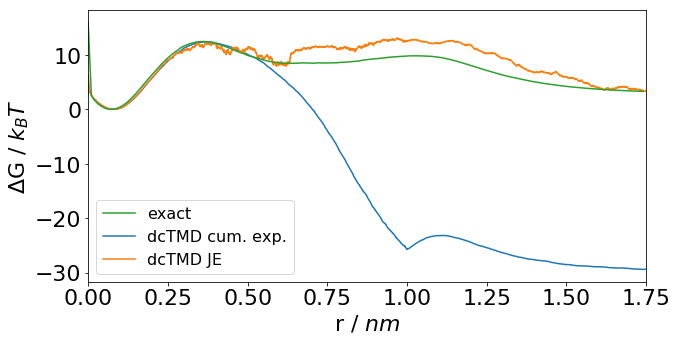

In [56]:
fig = plt.figure(figsize=(10, 5))

#dcTMD_Gauss, = plt.plot(x/10,corr_Gauss-np.min(corr_Gauss))
dcTMD_Gauss, = plt.plot(x/100,corr_Gauss-np.min(corr_Jarzy))
dcTMD_Jarzy, = plt.plot(x/100,corr_Jarzy-np.min(corr_Jarzy))
dG_statmech, = plt.plot(np.linspace(0,1.74,175),dG_TD-np.min(dG_TD))
#id_PMF, = plt.plot(np.linspace(0,17.4,175),id_TI-np.min(id_TI))

plt.legend((dG_statmech,dcTMD_Gauss,dcTMD_Jarzy),\
           ("exact","dcTMD cum. exp.","dcTMD JE"), prop={'size': 16})
#plt.legend((dG_statmech,id_PMF,dcTMD_Gauss,dcTMD_Jarzy),\
#           ("$\Delta$G part. funct.","$\Delta$G ideal TI","dcTMD Gauss","dcTMD JE"), prop={'size': 16})

plt.xlim(0.,1.75)

plt.xlabel('r / $nm$')
plt.ylabel('$\Delta$G / $k_BT$')
#plt.ylabel('r$Energy$ / $k_BT$')

plt.savefig('figs/MC_dcTMD_twoexits_corrections_vc0.02_newMC.pdf',bbox_inches='tight')

plt.show()

**pathway sorting:**

In [31]:
path1 = (np.linspace(170.,190.,41))
path2 = (np.linspace(260.,280.,41))

In [32]:
path1_list = []
path2_list = []
cross_list = []

ppath1_list = []
Wpath1_list = []
fcpath1_list = []

ppath2_list = []
Wpath2_list = []
fcpath2_list = []

pcross_list = []
Wcross_list = []
fccross_list = []

In [33]:
# analyze position in 2nd quarter of simulations

for i in range(dcTMD_runs):
    if True in np.in1d(np.around((p_dcTMD[i,int(175*0.25/vc):int(175*0.5/vc)]),decimals=-1),path1) and\
    not True in np.in1d(np.around((p_dcTMD[i,int(175*0.25/vc):int(175*0.5/vc)]),decimals=-1),path2): 
        path1_list.append(i)
    elif True in np.in1d(np.around((p_dcTMD[i,int(175*0.25/vc):int(175*0.5/vc)]),decimals=-1),path2) and\
    not True in np.in1d(np.around((p_dcTMD[i,int(175*0.25/vc):int(175*0.5/vc)]),decimals=-1),path1):
        path2_list.append(i)
    else:
        cross_list.append(i)

In [34]:
for i in path1_list:
    ppath1_list.append(p_dcTMD[i,:])
    Wpath1_list.append(W_dcTMD[i,:])
    fcpath1_list.append(fc_dcTMD[i,:])

for i in path2_list:
    ppath2_list.append(p_dcTMD[i,:])
    Wpath2_list.append(W_dcTMD[i,:])
    fcpath2_list.append(fc_dcTMD[i,:])
    
for i in cross_list:
    pcross_list.append(p_dcTMD[i,:])
    Wcross_list.append(W_dcTMD[i,:])
    fccross_list.append(fc_dcTMD[i,:])
    
ppath1 = np.asarray(ppath1_list)
Wpath1 = np.asarray(Wpath1_list)
fcpath1 = np.asarray(fcpath1_list)

ppath2 = np.asarray(ppath2_list)
Wpath2 = np.asarray(Wpath2_list)
fcpath2 = np.asarray(fcpath2_list)

pcross = np.asarray(pcross_list)
Wcross = np.asarray(Wcross_list)
fccross = np.asarray(fccross_list)

In [35]:
N1 = len(ppath1[:,0])

In [36]:
N1

1106

In [37]:
N2 = len(ppath2[:,0])

In [38]:
N2

3676

In [39]:
Ncross = len(pcross[:,0])

In [40]:
Ncross

218

In [41]:
box_counts_path1 = np.zeros([len(R),len(phi)])
box_counts_path2 = np.zeros([len(R),len(phi)])
box_counts_cross = np.zeros([len(R),len(phi)])

In [42]:
for i in range(len(ppath1[:,0])):
    if i % 10 == 0:
        print("iteration ",i)
    for j in range(int(175/vc)):
        box_counts_path1[int(j*vc),int(ppath1[i,j])] += 1

iteration  0
iteration  10
iteration  20
iteration  30
iteration  40
iteration  50
iteration  60
iteration  70
iteration  80
iteration  90
iteration  100
iteration  110
iteration  120
iteration  130
iteration  140
iteration  150
iteration  160
iteration  170
iteration  180
iteration  190
iteration  200
iteration  210
iteration  220
iteration  230
iteration  240
iteration  250
iteration  260
iteration  270
iteration  280
iteration  290
iteration  300
iteration  310
iteration  320
iteration  330
iteration  340
iteration  350
iteration  360
iteration  370
iteration  380
iteration  390
iteration  400
iteration  410
iteration  420
iteration  430
iteration  440
iteration  450
iteration  460
iteration  470
iteration  480
iteration  490
iteration  500
iteration  510
iteration  520
iteration  530
iteration  540
iteration  550
iteration  560
iteration  570
iteration  580
iteration  590
iteration  600
iteration  610
iteration  620
iteration  630
iteration  640
iteration  650
iteration  660
iterat

In [43]:
for i in range(len(np.asarray(ppath2_list)[:,0])):
    if i % 10 == 0:
        print("iteration ",i)
    for j in range(int(175/vc)):
        box_counts_path2[int(j*vc),int(ppath2[i,j])] += 1

iteration  0
iteration  10
iteration  20
iteration  30
iteration  40
iteration  50
iteration  60
iteration  70
iteration  80
iteration  90
iteration  100
iteration  110
iteration  120
iteration  130
iteration  140
iteration  150
iteration  160
iteration  170
iteration  180
iteration  190
iteration  200
iteration  210
iteration  220
iteration  230
iteration  240
iteration  250
iteration  260
iteration  270
iteration  280
iteration  290
iteration  300
iteration  310
iteration  320
iteration  330
iteration  340
iteration  350
iteration  360
iteration  370
iteration  380
iteration  390
iteration  400
iteration  410
iteration  420
iteration  430
iteration  440
iteration  450
iteration  460
iteration  470
iteration  480
iteration  490
iteration  500
iteration  510
iteration  520
iteration  530
iteration  540
iteration  550
iteration  560
iteration  570
iteration  580
iteration  590
iteration  600
iteration  610
iteration  620
iteration  630
iteration  640
iteration  650
iteration  660
iterat

In [44]:
for i in range(len(np.asarray(pcross_list)[:,0])):
    if i % 10 == 0:
        print("iteration ",i)
    for j in range(int(175/vc)):
        box_counts_cross[int(j*vc),int(pcross[i,j])] += 1

iteration  0
iteration  10
iteration  20
iteration  30
iteration  40
iteration  50
iteration  60
iteration  70
iteration  80
iteration  90
iteration  100
iteration  110
iteration  120
iteration  130
iteration  140
iteration  150
iteration  160
iteration  170
iteration  180
iteration  190
iteration  200
iteration  210


/Users/Steffen/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log


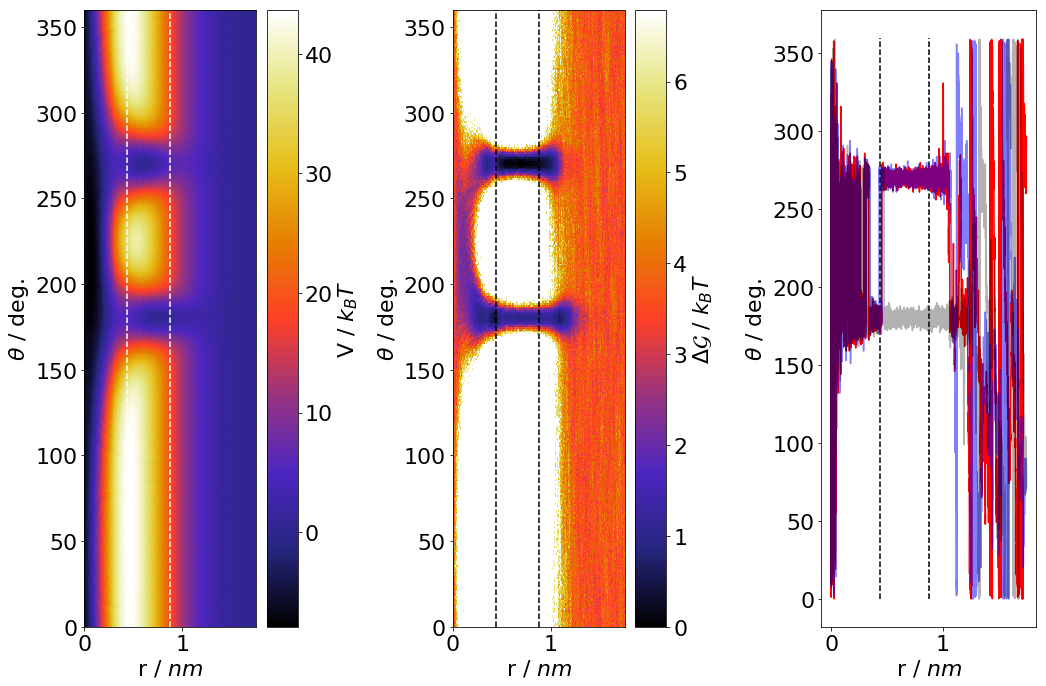

In [47]:
fig = plt.figure(figsize=(15, 10))
#plt.subplots_adjust(right=0.5)

#plt.subplot(1,3,1)
##plt.imshow(Boltz_weight)
#plt.imshow(ray,origin='lower',aspect='auto')
#plt.xlabel('R / $10^{-1} \AA$')
#plt.ylabel(r'$\theta$ / 0.5 deg.')
#plt.colorbar().set_label('V / $k_BT$')
plt.subplot(1,3,1)
plt.imshow(ray,origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,1.75,0.,360.])
plt.vlines(1.75*0.25,0,360,linestyles='dashed',color='white')
plt.vlines(1.75*0.5,0,360,linestyles='dashed',color='white')
plt.xlabel('r / $nm$')
plt.ylabel(r'$\theta$ / deg.')
plt.colorbar().set_label('V / $k_BT$')

#plt.colorbar().set_label('V / $k_BT$')
plt.subplot(1,3,2)
plt.imshow(-np.log(box_counts_cross.T)-np.min(-np.log(box_counts_cross.T)),origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,1.75,0.,360.])
plt.vlines(1.75*0.25,0,360,linestyles='dashed')
plt.vlines(1.75*0.5,0,360,linestyles='dashed')
plt.xlabel('r / $nm$')
plt.ylabel(r'$\theta$ / deg.')
plt.colorbar().set_label('$\Delta \mathcal{G}$ / $k_BT$')

plt.subplot(1,3,3)
#plt.imshow(ray,origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,17.5,0.,360.])
plt.plot(x/100,pcross_list[2],'r-')
plt.plot(x/100,pcross_list[10],'b-',alpha=0.5)
plt.plot(x/100,pcross_list[196],'k-',alpha=0.3)
plt.vlines(1.75*0.25,0,360,linestyles='dashed')
plt.vlines(1.75*0.5,0,360,linestyles='dashed')
plt.xlabel('r / $nm$')
plt.ylabel(r'$\theta$ / deg.')

fig.tight_layout()
plt.savefig('figs/dcTMDruns_vc0.02_crosser_newMC.pdf',bbox_inches='tight',origin='lower')
plt.show()

/Users/Steffen/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/Users/Steffen/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log
/Users/Steffen/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


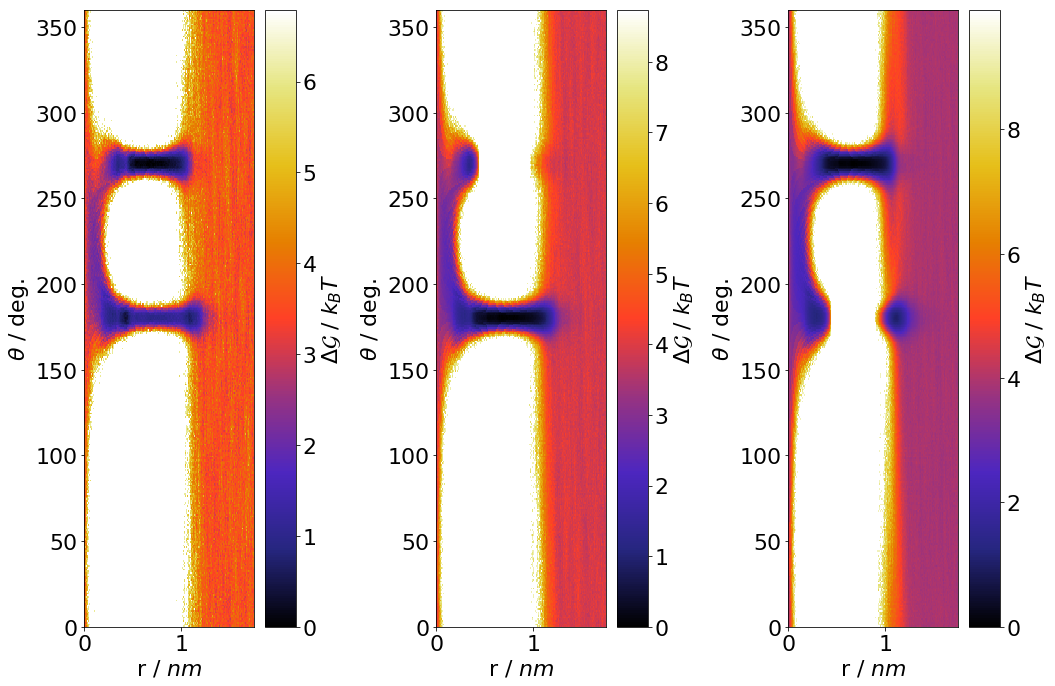

In [46]:
fig = plt.figure(figsize=(15, 10))
#plt.subplots_adjust(right=0.5)

plt.subplot(1,3,1)
plt.imshow(-np.log(box_counts_cross.T)-np.min(-np.log(box_counts_cross.T)),origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,1.75,0.,360.])
plt.xlabel('r / $nm$')
plt.ylabel(r'$\theta$ / deg.')
plt.colorbar().set_label('$\Delta \mathcal{G}$ / $k_BT$')

plt.subplot(1,3,2)
plt.imshow(-np.log(box_counts_path1.T)-np.min(-np.log(box_counts_path1.T)),origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,1.75,0.,360.])
plt.xlabel('r / $nm$')
plt.ylabel(r'$\theta$ / deg.')
plt.colorbar().set_label('$\Delta \mathcal{G}$ / $k_BT$')
plt.subplot(1,3,3)
plt.imshow(-np.log(box_counts_path2.T)-np.min(-np.log(box_counts_path2.T)),origin='lower',aspect='auto',cmap=cm.CMRmap,extent=[0,1.75,0.,360.])
plt.xlabel('r / $nm$')
plt.ylabel(r'$\theta$ / deg.')
plt.colorbar().set_label('$\Delta \mathcal{G}$ / $k_BT$')

fig.tight_layout()
plt.savefig('figs/dcTMDruns_twoexits_pathsep_vc0.02_newMC.pdf',bbox_inches='tight',origin='lower')
plt.show()

**analysis**

In [48]:
corr_Gauss_path1 = np.zeros(len(fc_dcTMD[0,:]))
corr_Gauss_path2 = np.zeros(len(fc_dcTMD[0,:]))

In [49]:
for i in range(1,len(fc_dcTMD[0,:])):
    corr_Gauss_path1[i] = Gaussy(Wpath1[:,i]) - RT*np.log(np.linspace(0,175,int(box[0]/vc))[i]) #last term is a projection artefact correction
    corr_Gauss_path2[i] = Gaussy(Wpath2[:,i]) - RT*np.log(np.linspace(0,175,int(box[0]/vc))[i]) #last term is a projection artefact correction

In [50]:
corr_Gauss_pathcombined = -RT*np.log( (1/(N1+N2)) * (N1*np.exp(-corr_Gauss_path1/RT) + N2*np.exp(-corr_Gauss_path2/RT)) )

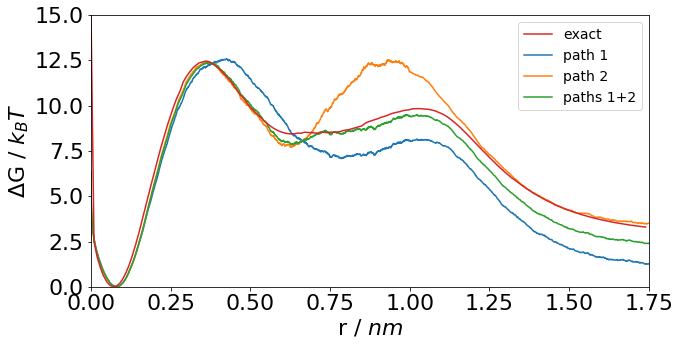

In [54]:
fig = plt.figure(figsize=(10, 5))

dcTMD_Gauss_path1, = plt.plot(x/100,corr_Gauss_path1-np.min(corr_Gauss_path1))
dcTMD_Gauss_path2, = plt.plot(x/100,corr_Gauss_path2-np.min(corr_Gauss_path2))
dcTMD_Gauss_pathcombi, = plt.plot(x/100,corr_Gauss_pathcombined-np.min(corr_Gauss_pathcombined))

dG_statmech, = plt.plot(np.linspace(0,1.74,175),dG_TD-np.min(dG_TD))
#id_PMF, = plt.plot(np.linspace(0,17.4,175),id_TI-np.min(id_TI))

plt.legend((dG_statmech,dcTMD_Gauss_path1,dcTMD_Gauss_path2,dcTMD_Gauss_pathcombi),\
           ("exact","path 1","path 2","paths 1+2"),\
           prop={'size': 14})
#plt.legend((dG_statmech,id_PMF,dcTMD_Gauss_path1,dcTMD_Gauss_path2,dcTMD_Gauss_pathcombi),\
#           ("$\Delta$G part. funct.","$\Delta$G ideal TI","path 1","path 2","$\Delta$G paths combi."),\
#           prop={'size': 14})


plt.xlim(0.,1.75)
plt.ylim(0.,15.)
plt.xlabel('r / $nm$')
#plt.ylabel('Energy / $k_BT$')
plt.ylabel('$\Delta$G / $k_BT$')

plt.savefig('figs/MC_dcTMD_twoexits_corrections_path1_vc0.02_newMC.pdf',bbox_inches='tight') #N1 = 

plt.show()

* work distribution analysis

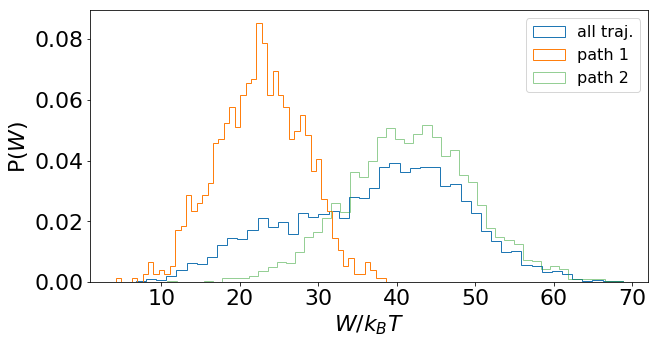

In [46]:
fig = plt.figure(figsize=(10, 5))
plt.hist(W_dcTMD[:,5000],bins=50,normed=True, histtype='step')
plt.hist(Wpath1[:,5000],bins=50,normed=True, histtype='step')
plt.hist(Wpath2[:,5000],bins=50,normed=True, histtype='step', alpha=0.5)
plt.xlabel('$W / k_BT$')
plt.ylabel('P($W$)')
plt.legend(("all traj.","path 1","path 2"),\
           prop={'size': 16})

plt.savefig('figs/dcTMDruns_compareWdistrib_R150_vc0.02_newMC_separated.pdf',bbox_inches='tight',origin='lower')
plt.show()

* estimating equilibrium probabilities path 1 (N1) and path 2 (N2)

In [69]:
(N1/(N1+N2))*np.trapz(np.exp(-(corr_Gauss_path1)/RT),dx=0.00025)/\
np.trapz(np.exp(-(corr_Gauss_pathcombined)/RT),dx=0.00025)

0.34190554755008817

In [72]:
(N2/(N1+N2))*np.trapz(np.exp(-(corr_Gauss_path2)/RT),dx=0.00025)/\
np.trapz(np.exp(-(corr_Gauss_pathcombined)/RT),dx=0.00025)

0.65809445244991194

* recover friction estimates

In [74]:
Gamma_Gauss_path1 = Gamma(Wpath1,0.025)
Gamma_Gauss_path2 = Gamma(Wpath2,0.025)

In [75]:
#smoothing

window = 50

smooth_Gamma_Gauss_path1 = np.convolve(Gamma_Gauss_path1, np.ones((window,))/window, mode='same')
smooth_Gamma_Gauss_path2 = np.convolve(Gamma_Gauss_path2, np.ones((window,))/window, mode='same')

In [77]:
Gamma_extended_field = np.ones((len(phi),len(R)*40))

for phi_i in range(len(phi)):
    for R_i in range(400,4000):
        if (phi_i > 140 and phi_i < 220):
            Gamma_extended_field[phi_i,R_i] = 5 #in k_BT \Delta t/\AA^{2}
        else:
            Gamma_extended_field[phi_i,R_i] = 15 #10 #7

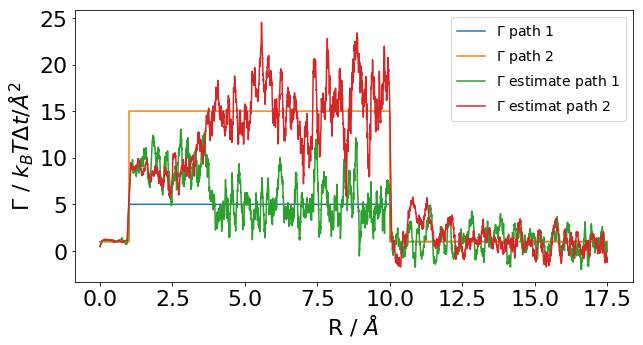

In [52]:
fig = plt.figure(figsize=(10, 5))

true_Gamma_path1,  = plt.plot(x/10,Gamma_extended_field[180,:])
true_Gamma_path2,  = plt.plot(x/10,Gamma_extended_field[270,:])
dcTMD_Gauss_path1, = plt.plot(x/10,smooth_Gamma_Gauss_path1)
dcTMD_Gauss_path2, = plt.plot(x/10,smooth_Gamma_Gauss_path2)

plt.legend((true_Gamma_path1,true_Gamma_path2,dcTMD_Gauss_path1,dcTMD_Gauss_path2),\
           ("$\Gamma$ path 1","$\Gamma$ path 2","$\Gamma$ estimate path 1","$\Gamma$ estimat path 2"),\
           prop={'size': 14})

plt.xlabel('R / $\AA$')
plt.ylabel('$\Gamma$ / $k_BT \Delta t/\AA^{2}$' )

plt.savefig('figs/MC_dcTMD_twoexits_corrections_Gammaestimate_vc0.02_newMC.pdf',bbox_inches='tight')

plt.show()